In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import codedapertures as ca
import scipy as sp

from utils import get_objects_from_config
from experiment import CodApSimulator, play_simulation
from image_preprocessing import process_image

# <center> First attempt on simulating Coded Aperture (DEPRECATED) </center>

This notebook is a first attempt on simulating light coming out of a screen as single photons, passing through a single hole, projecting onto a flat sensor.

The degrees of fredom would be:
1. Distance between each screen
2. Solid angle limits of emision (for now, we fix it at 360 for $\theta$, and 90 for $\phi$)
3. Number of photons coming out of each pixel
4. Resolution: Number of pixels on the light source
5. Dimention of each screen

For now, 1, 4 and 5 will be fixed.

# Testing Image Prepocessing

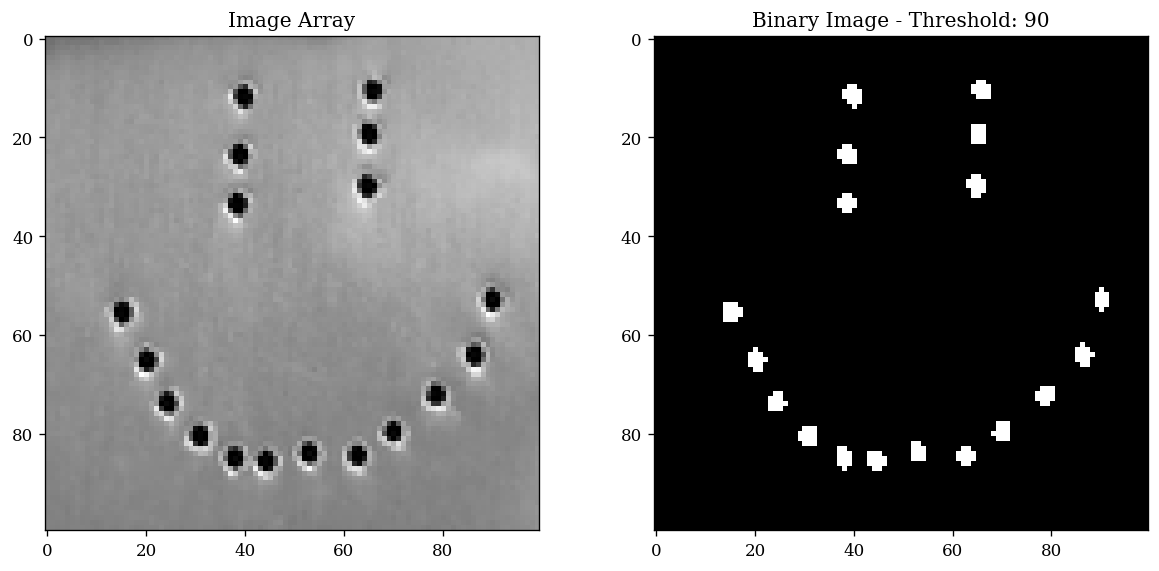

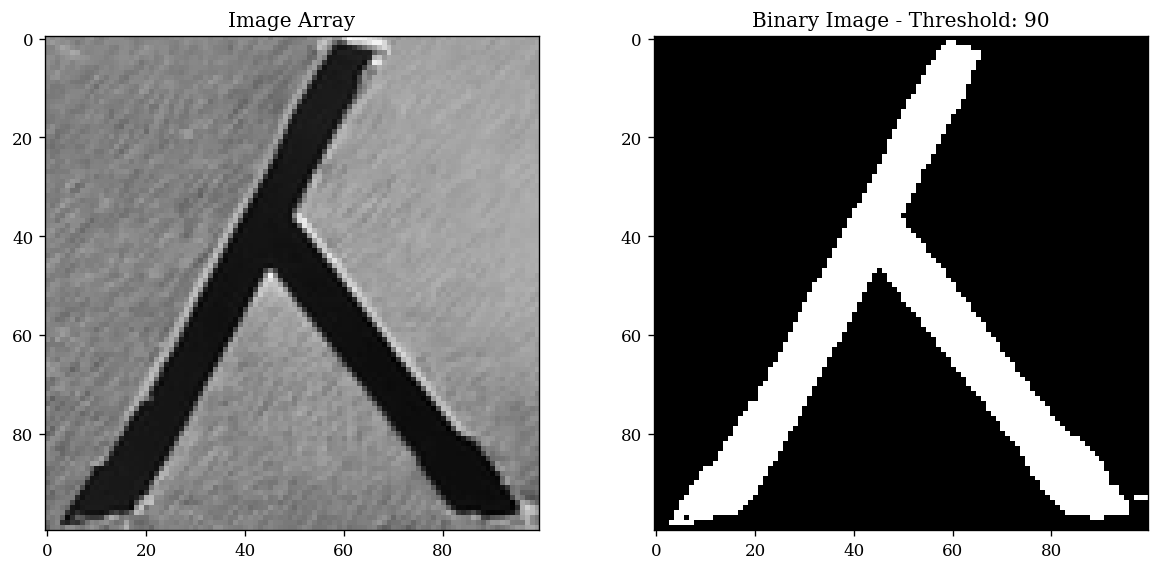

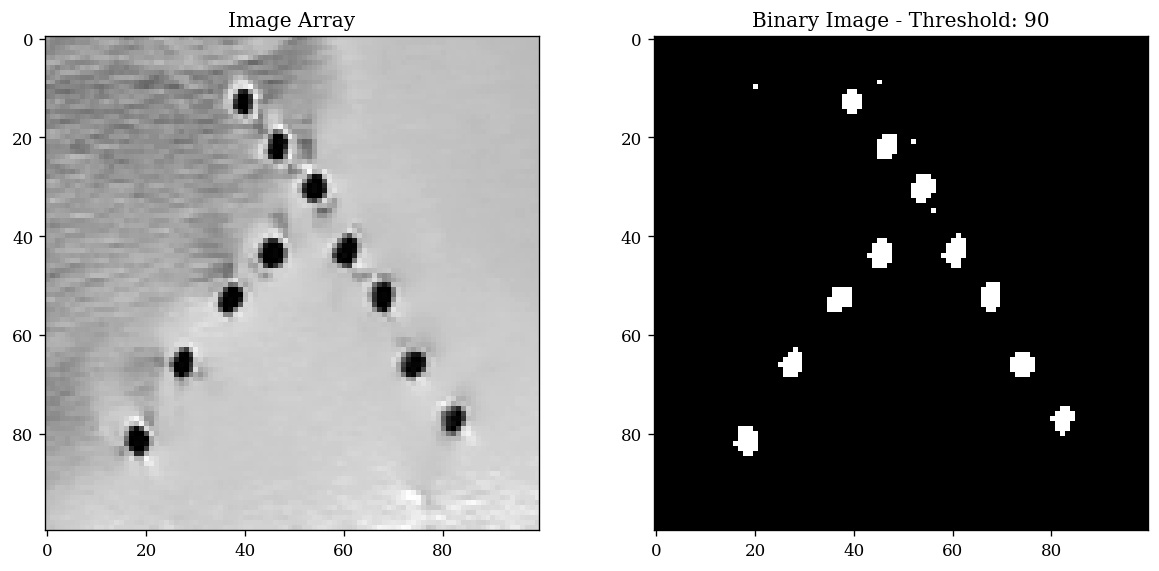

In [2]:
names = ['face_pinhole', 'lambda_letter_srce', 'lambda_letter_pinhole']
types = ['jpg', 'png', 'png']
for i in range(len(names)):
    img, binary_img = process_image(names[i], type=types[i], invert = True)

# Testing full pipeline

In [2]:
config_path = "config.json"
source, slit, sensor, options = get_objects_from_config(config_path)
simulator = CodApSimulator(
    options=options, source=source, slit=slit, sensor=sensor
)
play_simulation(simulator, config_path)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 122/50000 [00:00<00:41, 1215.80it/s]

Simulating the propagation of photons through the slit...


100%|██████████| 50000/50000 [00:37<00:00, 1317.08it/s]

Adding noise to the image...
Done!
Saving results...


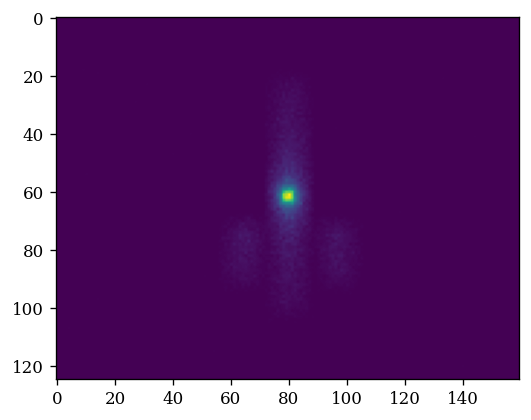

In [4]:
image = np.load('results\phi unveven slit_size and sensor_size\image.npy')
plt.imshow(image)

# Testing Decoding

## MURA

In [3]:
config_path = 'mura_experiment.json'
source, slit, sensor, options = get_objects_from_config(config_path=config_path)
simulator = CodApSimulator(source=source, slit=slit, sensor=sensor, options=options)

Modified Uniformly Redundant Array
----------------------------------
rank:   11
L:      101
tile:   (1, 1)
width:  101
height: 101
The chosen directory is not empty:
results/phi | mura | skipper 2
Continuing...


In [4]:
play_simulation(simulator=simulator, config_path='config.json')

Simulating the propagation of photons through the slit...


100%|██████████| 10000/10000 [00:03<00:00, 2823.08it/s]


Adding noise to the image...
decoding mura image...
Done!
Saving results...


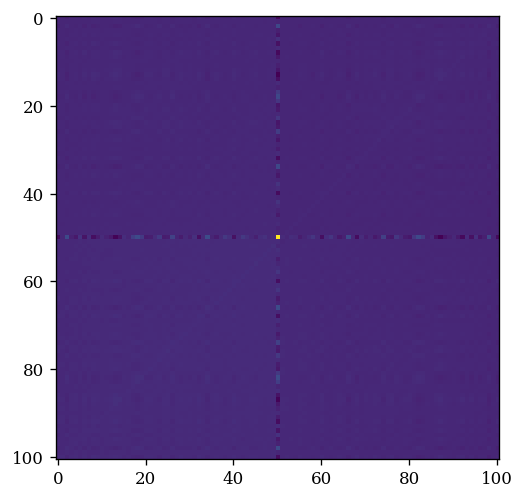

In [19]:
plt.imshow(sp.signal.correlate(simulator.slit.mask, simulator.decoding_pattern, mode='same'))

Modified Uniformly Redundant Array
----------------------------------
rank:   2
L:      17
tile:   (1, 1)
width:  17
height: 17


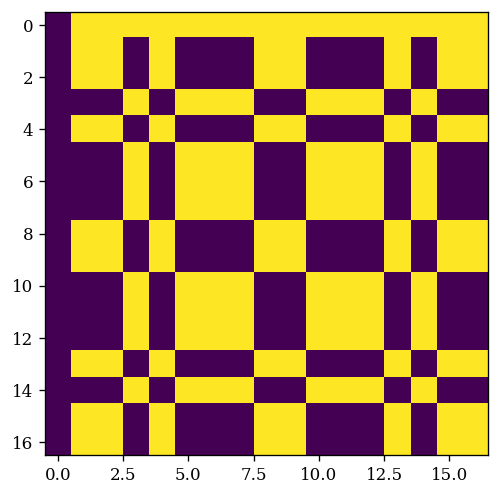

In [32]:
mura = ca.mura(rank=2, tile=1)
plt.imshow(mura.aperture)

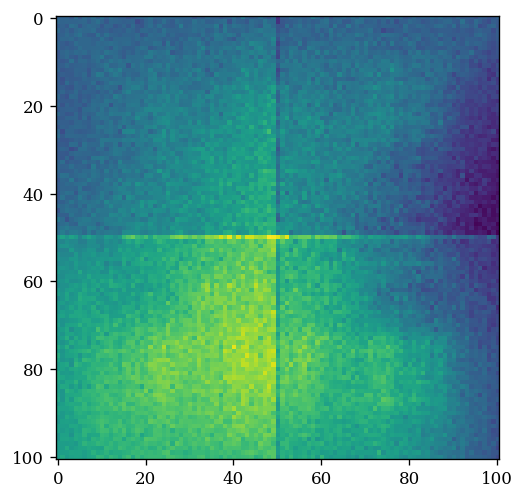

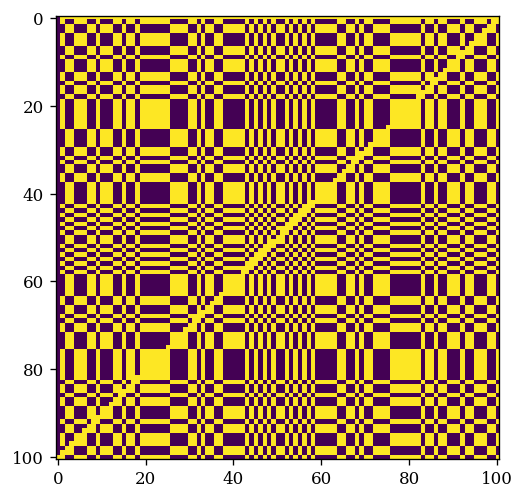

In [18]:
plt.imshow(sp.signal.correlate(simulator.sensor.screen, simulator.decoding_pattern, mode='same'))
plt.show()
plt.imshow(simulator.decoding_pattern)